<a href="https://colab.research.google.com/github/EduardoMoraesRitter/spark/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# multi-class
https://datascienceplus.com/multi-class-text-classification-with-pyspark/

https://www.youtube.com/watch?v=b8K_zEZBf9s

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 49.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=848f96e38671dca738a0d09b51ae50d095103a2b333bd5f70c9025f987d2627c
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("TextClassification") \
    .getOrCreate()

In [10]:
#https://www.kaggle.com/datasets/andrewmvd/udemy-courses

import pandas as pd

url = 'https://raw.githubusercontent.com/EduardoMoraesRitter/spark/main/dados/udemy_courses.csv'
df_pandas = pd.read_csv(url, index_col=0)
print(df_pandas.head(5))

                                                course_title  \
course_id                                                      
1070968                   Ultimate Investment Banking Course   
1113822    Complete GST Course & Certification - Grow You...   
1006314    Financial Modeling for Business Analysts and C...   
1210588    Beginner to Pro - Financial Analysis in Excel ...   
1011058         How To Maximize Your Profits Trading Options   

                                                         url  is_paid  price  \
course_id                                                                      
1070968    https://www.udemy.com/ultimate-investment-bank...     True    200   
1113822        https://www.udemy.com/goods-and-services-tax/     True     75   
1006314    https://www.udemy.com/financial-modeling-for-b...     True     45   
1210588    https://www.udemy.com/complete-excel-finance-c...     True     95   
1011058    https://www.udemy.com/how-to-maximize-your-pro...     True  

In [11]:
dados = spark.createDataFrame(df_pandas)
dados.limit(5).show()

+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+
|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|
+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+
|Ultimate Investme...|https://www.udemy...|   true|  200|           2147|         23|          51|        All Levels|             1.5|2017-01-18T20:58:58Z|Business Finance|
|Complete GST Cour...|https://www.udemy...|   true|   75|           2792|        923|         274|        All Levels|            39.0|2017-03-09T16:34:20Z|Business Finance|
|Financial Modelin...|https://www.udemy...|   true|   45|           2174|         74|          51|Intermediate Level|             2.5|2

In [12]:
print(dados.count())
len(dados.columns)

3678


11

In [13]:
dados.printSchema()

root
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: boolean (nullable = true)
 |-- price: long (nullable = true)
 |-- num_subscribers: long (nullable = true)
 |-- num_reviews: long (nullable = true)
 |-- num_lectures: long (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: double (nullable = true)
 |-- published_timestamp: string (nullable = true)
 |-- subject: string (nullable = true)



In [14]:
dados.limit(100).show()

+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|  content_duration| published_timestamp|         subject|
+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|Ultimate Investme...|https://www.udemy...|   true|  200|           2147|         23|          51|        All Levels|               1.5|2017-01-18T20:58:58Z|Business Finance|
|Complete GST Cour...|https://www.udemy...|   true|   75|           2792|        923|         274|        All Levels|              39.0|2017-03-09T16:34:20Z|Business Finance|
|Financial Modelin...|https://www.udemy...|   true|   45|           2174|         74|          51|Intermediate Level|        

In [15]:
dados.groupBy('subject').count().show()

+-------------------+-----+
|            subject|count|
+-------------------+-----+
|   Business Finance| 1195|
|     Graphic Design|  603|
|Musical Instruments|  680|
|    Web Development| 1200|
+-------------------+-----+



In [16]:
df = dados.select('course_title','subject')

In [18]:
from pyspark.sql.types import * 
from pyspark.sql.functions import *     

In [19]:
df.select([count(when(isnull(c), 1)).alias(c) for c in df.columns]).show()

+------------+-------+
|course_title|subject|
+------------+-------+
|           0|      0|
+------------+-------+



# PIPE

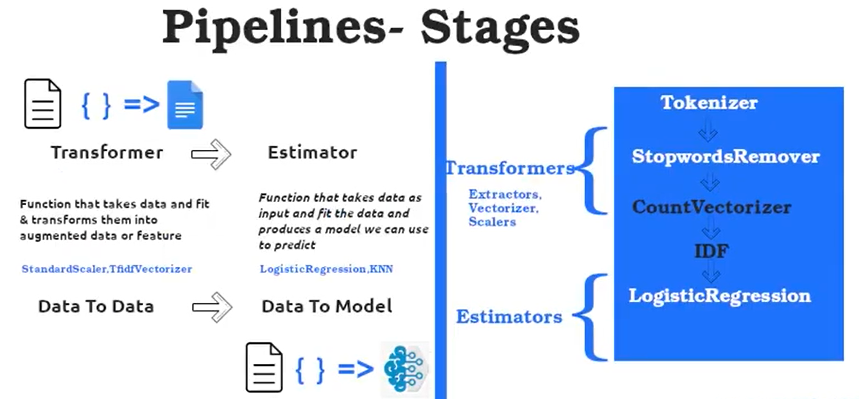

In [20]:
import pyspark.ml.feature

In [ ]:
dir(pyspark.ml.feature)

In [117]:
# label Encoding / Lavel Indexing 
from pyspark.ml.feature import StringIndexer

labelEncoder = StringIndexer(inputCol='subject', outputCol='label').fit(df)

labelDF = labelEncoder.transform(df)

labelDF.limit(5).show(truncate=False)

+-----------------------------------------------------------+----------------+-----+
|course_title                                               |subject         |label|
+-----------------------------------------------------------+----------------+-----+
|Ultimate Investment Banking Course                         |Business Finance|1.0  |
|Complete GST Course & Certification - Grow Your CA Practice|Business Finance|1.0  |
|Financial Modeling for Business Analysts and Consultants   |Business Finance|1.0  |
|Beginner to Pro - Financial Analysis in Excel 2017         |Business Finance|1.0  |
|How To Maximize Your Profits Trading Options               |Business Finance|1.0  |
+-----------------------------------------------------------+----------------+-----+



In [41]:
#amostra
train, test = labelDF.randomSplit([0.7, 0.3], seed=42)

In [42]:
#pipe e processos
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, HashingTF

#1 token
tokenizer = Tokenizer(inputCol='course_title', outputCol='mytokens')

#2 remover stopWord
stopword_remover = StopWordsRemover(inputCol='mytokens', outputCol='removed')

#3 vetor
vectorizer = CountVectorizer(inputCol='removed', outputCol='vetorized')

#4 idf balanciado
idf = IDF(inputCol='vetorized', outputCol='balanced')

In [43]:
#modelo
from pyspark.ml.classification import LogisticRegression

In [44]:
#5 estimator
lr = LogisticRegression(featuresCol='balanced', labelCol='label')

In [45]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[tokenizer, stopword_remover, vectorizer, idf, lr])
print(pipeline)
print(pipeline.stages)

Pipeline_2fea66522795
Pipeline_2fea66522795__stages


In [46]:
#treinar
lr_model = pipeline.fit(train)
lr_model

PipelineModel_d5f08a58dcf0

In [55]:
#predizer
predictions = lr_model.transform(test)
predictions.show()

+--------------------+-------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        course_title|            subject|label|            mytokens|             removed|           vetorized|            balanced|       rawPrediction|         probability|prediction|
+--------------------+-------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|#12 Hand Coordina...|Musical Instruments|  2.0|[#12, hand, coord...|[#12, hand, coord...|(3701,[363,597,67...|(3701,[363,597,67...|[3.49840125714720...|[0.85541251159737...|       0.0|
|* An Integrated A...|   Business Finance|  1.0|[*, an, integrate...|[*, integrated, a...|(3701,[31,71,581]...|(3701,[31,71,581]...|[-6.1326095106357...|[1.10442420459782...|       1.0|
|1. Principles of ...|   Business Finance|  1.0|[1., principles, ...|[

# Evaluation

*   Accuracy
*   Precision
*   Recall
*   F1score

In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [57]:
accuracy = MulticlassClassificationEvaluator(labelCol='label', 
                                               predictionCol='prediction', 
                                               metricName='accuracy')

accuracy.evaluate(predictions)

0.9364326375711575

In [54]:
# metrics
from pyspark.mllib.evaluation import MulticlassMetrics

In [66]:
lr_metric = MulticlassMetrics(predictions['label', 'prediction'].rdd)

print("accuracy",lr_metric.accuracy)
print("precision",lr_metric.precision(1.0))
print("recall",lr_metric.recall(1.0))
print("F1Score",lr_metric.fMeasure(1.0))

accuracy 0.9364326375711575
precision 0.9611940298507463
recall 0.9096045197740112
F1Score 0.9346879535558782


In [114]:
#filtar a label
labels = dados.select(['subject']).dropDuplicates(['subject']).toPandas()
labels = labels['subject'].to_numpy()
labels

array(['Business Finance', 'Graphic Design', 'Musical Instruments',
       'Web Development'], dtype=object)

In [105]:
# matriz de confução
df_cm = lr_metric.confusionMatrix().toArray()
df_cm

array([[349.,   8.,   5.,   8.],
       [  7., 322.,  11.,  14.],
       [  1.,   2., 178.,   1.],
       [  5.,   3.,   2., 138.]])

In [115]:
df_matrix = pd.DataFrame(df_cm, index = labels, columns = labels)
df_matrix

,Business Finance,Graphic Design,Musical Instruments,Web Development
Business Finance,349.0,8.0,5.0,8.0
Graphic Design,7.0,322.0,11.0,14.0
Musical Instruments,1.0,2.0,178.0,1.0
Web Development,5.0,3.0,2.0,138.0


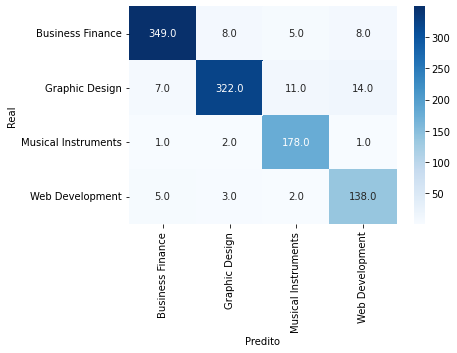

In [116]:
import seaborn as sn

s = sn.heatmap(df_matrix, annot=True, cmap='Blues', fmt='.4')
s.set(xlabel='Predito', ylabel='Real');

# Teste

In [119]:
teste = spark.createDataFrame([
    ('Business Analysts and Consultants', StringType())], 
    ["course_title"])

teste.show()

+--------------------+---+
|        course_title| _2|
+--------------------+---+
|Business Analysts...| {}|
+--------------------+---+



In [123]:
pred = lr_model.transform(teste)

pred.show()

+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        course_title| _2|            mytokens|             removed|           vetorized|            balanced|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Business Analysts...| {}|[business, analys...|[business, analys...|(3701,[50,638],[1...|(3701,[50,638],[4...|[-2.9759905335450...|[3.25566634542569...|       1.0|
+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+



# salvar modelo

In [128]:
path = 'model/pyspark_model_2021'

In [126]:
# salvar modelo
lr_model.save(path)

In [129]:
# carregar modelo
from pyspark.ml.pipeline import PipelineModel

model = PipelineModel.load(path)
model

PipelineModel_d5f08a58dcf0